In [1]:
import numpy as np
import pandas as pd
import fiona
import geopandas as gpd
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [3]:
# Data import
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\DRC"
acasus = gpd.read_file(dataDir+"\\DRC_HF_acasus_iss.gdb", driver='FileGDB', 
                       layer= 'DRC_Acasus_health_facility_all_merged')
who = gpd.read_file(dataDir+"\\DRC_HF_acasus_iss.gdb", driver='FileGDB', 
                       layer= 'DRC_WHO_health_facility_all_merged')
dataDir2 = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\Fuzzy Match Testing"
who_seq = gpd.read_file(dataDir2+"\\Fuzzy Match Testing.gdb", driver='FileGDB', 
                       layer= 'WHO_identical')

## Data preprocessing

In [4]:
# merge feature sequence to original dataset
# use FEAT_SEQ in acasus

# minus 1 from IN_FID in who_seq to match index of the original dataset
who_seq['IN_FID'] = who_seq['IN_FID']-1
# drop duplicates in IN_FID since some points are assigned to more than 1 cluster
who_seq = who_seq.sort_values(by=['IN_FID', 'FEAT_SEQ'])\
.drop_duplicates(subset='IN_FID', keep='first')
# add feature sequence to original dataset
who = who.merge(who_seq.drop(columns=['geometry']), left_index=True, right_on='IN_FID')

In [5]:
# Obtain lat and long
acasus['geometry'] = acasus['geometry'].to_crs(epsg=4326)
acasus['latitude'] = acasus['geometry'].y
acasus['longitude'] = acasus['geometry'].x

who['geometry'] = who['geometry'].to_crs(epsg=4326)
who['latitude'] = who['geometry'].y
who['longitude'] = who['geometry'].x

In [6]:
# create the date column
acasus.rename(columns={'day':'day_original'},
             inplace=True)
# replace day values of 0 with 1 to create date column
acasus['day'] = acasus['day_original'].replace(0,1)
acasus['date'] = pd.to_datetime(acasus[['year', 'month', 'day']])
# convert date column to datetime 
who['date_dt'] = pd.to_datetime(who['date'])

In [7]:
def create_name_type(df, name_col, type_col, suffix, na_values):
    
    """Create the name type column,
    also encode common NA strings like 'NA' as NA.
    
    suffix: suffix of the cleaned name and type columns.
    na_values: list of strings that should be encoded as NA."""
    
    for na in na_values:
    
        df[type_col+suffix] = df[type_col].str.strip()\
        .replace(na, np.nan).replace('', np.nan)
    
        df[name_col+suffix] = df[name_col].str.strip()\
        .replace(na, np.nan).replace('', np.nan)

    df[name_col+'_'+type_col] = df[name_col+suffix].str.cat(df[type_col+suffix], sep=' ', na_rep='') \
    .str.strip()    
    
    return df

In [8]:
acasus_cleaned = create_name_type(acasus, name_col='face_name2', type_col='type', 
                 suffix='_corr', na_values=['NA'])
who_cleaned = create_name_type(who, name_col='face_name2', type_col='type', 
                 suffix='_corr', na_values=['NA', "Na"])

## Define functions

In [9]:
def find_subclusters(df, name='Facility_Name', clean_name='Short_Name',
                     cluster='FEAT_SEQ', date='date', fac_type='type',
                     simple_score=80, simple_score_min=50, 
                     partial_score=80, partial_score2=90):
    """
    name: column name for facility name
    clean_name: column name for cleaned short facility name
    cluster: feature sequence based on spatial proximity
    """

    # strip whitespaces to remove empty strings like ' '
    df[name]=df[name].str.strip()
    # replace empty string with NA
    df[name].replace('',np.nan,inplace=True)
    df[name].replace('NA',np.nan,inplace=True)
    
    # if the cleaned short name is NA, just use original facility name instead
    names = []
    for idx, row in df.iterrows():
        if isinstance(row[clean_name], str):
            names.append(row[clean_name])
        else:
            names.append(row[name])
    df[clean_name] = names 
    
    # drop NA in short name
    print("Number of NA values in name column:", df[clean_name].isna().sum())
    df.dropna(subset=[clean_name], inplace=True)

    counts = df.groupby(cluster).size()
    counts = pd.DataFrame({'freq_count':counts})
    counts.reset_index(inplace=True)

    # join back to the original dataframe
    df = df.merge(counts, on =[cluster])

    # sort values based on feature sequence and short name
    df.sort_values(by=[cluster, clean_name, date], inplace=True)
    # group by feature sequence
    df_grouped = df.groupby(cluster)

    # store the matched name
    match_names = []
    # store count of subclusters
    sub_counts = []
    # store score of matching
    match_scores = []
    # store types of matching
    match_types = []

    for group_name, df_group in df_grouped:
        # obtain list of names
        names = df_group[clean_name].to_list()
        
        # use the first name as the potential candidates for finding a match
        match_candidates = [names[0]]
        match_names.append(names[0])
        match_scores.append(np.nan)
        match_types.append('Self')

        for i in range(1, len(names)):

            name = names[i]

            # use match candidates to find best match and compute match score
            match_name1, score1 = process.extractOne(name, match_candidates, scorer = fuzz.ratio)
            match_name2, score2 = process.extractOne(name, match_candidates, scorer = fuzz.partial_ratio)

            # score based on simple ratio
            # or for very short strings, a single letter difference will result in low score
            # consider two short strings as a match if there's only 1 letter difference
            if score1>=simple_score or (1-score1/100) * len(name) <= 1:
                # append match name and score
                match_names.append(match_name1)
                match_scores.append(score1)
                match_types.append('Simple match')

            # if simple ratio not that high, check partial ratio
            elif score1>=simple_score_min and score2>=partial_score:
                # append match name and score
                match_names.append(match_name2)
                match_scores.append(score2)
                match_types.append('Partial match')

            elif score1>=simple_score_min:
                # check scores again after sorting the letters in names individually
                match_candidates2 = [''.join(sorted(candidate)) for candidate in match_candidates]
                match_name3, score3 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.ratio)
                match_name4, score4 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.partial_ratio)

                # or for very short strings, a single letter difference will result in low score
                # consider two short strings as a match if there's only 1 letter difference
                if score3>=simple_score or (1-score3/100) * len(name) <= 1:
                    # append match name and score
                    index = match_candidates2.index(match_name3)
                    match_names.append(match_candidates[index])
                    match_scores.append(score3)
                    match_types.append('Sorted simple match')

                # if simple ratio not that high, check partial ratio
                elif score3>=simple_score_min and score4>=partial_score2:
                    # append match name and score
                    index = match_candidates2.index(match_name4)
                    match_names.append(match_candidates[index])
                    match_scores.append(score4)
                    match_types.append('Sorted partial match')

                # if nothing above works, add the name to match candidates
                else:
                    match_candidates.append(name)
                    match_names.append(name)
                    match_scores.append(np.nan)
                    match_types.append('Self')

            # the match score based on simple ratio is lower than the minimum required
            # just match the name to itself and add it to match candidates
            else:
                match_candidates.append(name)
                match_names.append(name)
                match_scores.append(np.nan)
                match_types.append('Self')

        for i in range(len(names)):
            sub_counts.append(len(match_candidates))
    
    df['match_name'] = match_names
    df['n_subclusters'] = sub_counts
    df['match_score'] = match_scores
    df['match_type'] = match_types
    
    def rank(s):
        return s.rank(method='dense')
    
    # assign a sub sequence number
    df['name_seq'] = df.groupby(cluster)['match_name'].apply(rank)
    df['name_seq'].fillna(0, inplace=True)
    
    df['type_seq'] = df.groupby([cluster, 'name_seq'])[fac_type].apply(rank)
    df['type_seq'].fillna(0, inplace=True)
    
    df['clusterID'] = pd.Series(df[cluster]*100000+df['name_seq']*100+df['type_seq']).astype('int')
    
    df.sort_values(by=['clusterID'], inplace=True)
    
    return df

In [10]:
def cal_cluster_ratio(df, clusterID='clusterID', freq='freq_count',
                     date = 'date'):
    """
    Calculate cluster ratio after fuzzy match.
    
    freq: column name for number of points within a cluster
    """

    res = df.groupby([clusterID])\
    .agg(cluster_size=(freq, 'max'), subcluster_size=(freq,'count'))
    res['cluster_ratio'] = res['subcluster_size']/res['cluster_size']
    res.reset_index(inplace=True)
    df = df.merge(res, on=[clusterID])
    df = df.sort_values(by=[clusterID, 'cluster_ratio', date])
    
    return df

In [20]:
def eval_points(df, cluster = 'FEAT_SEQ',
                cluster_size = 'cluster_size', subcluster_size = 'subcluster_size',
                num_subclusters = 'n_subclusters', ratio = 'cluster_ratio',
               new_col='eval'):
    """Implement a decision tree to evalute subclusters and create an `eval` column.
    Possible values include 0 (to be dropped), 1 (good point to be kept) and
    2 (point that needs further examination)
    """

    evaluation = []

    clusters = df.groupby(cluster)

    for group_name, group_df in clusters:

        # number of points in the cluster
        N = group_df[cluster_size].iloc[0]
        # number of subclusters within the cluster
        m = group_df[num_subclusters].iloc[0]

        # Single point clusters
        if N==1:
            evaluation.append(2)

        # Two point clusters
        elif N==2:
            for idx, row in group_df.iterrows():
                # two points agree
                if row[ratio]==1:
                    evaluation.append(1)
                else:
                    evaluation.append(2)

        elif N==3:
            for idx, row in group_df.iterrows():
                # keep points with ratio >= 2/3, further evaluate the remaining points
                if row[ratio]>0.66:
                    evaluation.append(1)
                else:
                    evaluation.append(2)   

        elif N==4:
            # every point disagrees
            if m==4:
                for idx, row in group_df.iterrows():
                    evaluation.append(2)
            else:
                for idx, row in group_df.iterrows():
                    # keep points with ratio greater than or equal to 0.5
                    if row[ratio]>=0.5:
                        evaluation.append(1)
                    else:
                        evaluation.append(0)
        # cluster size greater than 4
        else:
            for idx, row in group_df.iterrows():
                if row[ratio]<=0.2:
                    evaluation.append(0)
                elif row[ratio]>0.2 and row[ratio]<0.5:
                    evaluation.append(2)
                else:
                    evaluation.append(1)

    df[new_col] = evaluation     
    return df

In [11]:
def drop_points(df, decision = 'eval', clusterID = 'clusterID'):
    """Drop subclusters with eval of 0,
    keep the last point in subclusters with eval of 1 or 2.
    decision: column name that contains evaluation of points."""
    
    df = df[df[decision]!=0]
    
    df_dropped = df.drop_duplicates(subset=[clusterID], keep='last')
    
    return df_dropped

## Acasus

In [12]:
# find subclusters
acasus_processed = find_subclusters(acasus_cleaned, name='face_name1', 
                                    clean_name='face_name2_corr', cluster='FEAT_SEQ',
                                    fac_type='type_corr',
                                    simple_score=90, simple_score_min=50, 
                                    partial_score=90, partial_score2=95)

Number of NA values in name column: 0


In [13]:
print("Number of subclusters:", acasus_processed['clusterID'].nunique())

Number of subclusters: 13918


In [17]:
# calculate cluster ratio
acasus_ratio = cal_cluster_ratio(acasus_processed)

Text(0.5, 1.0, 'Acasus: histogram of cluster ratio')

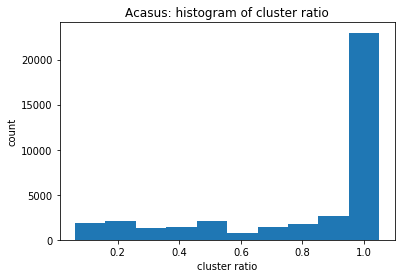

In [18]:
f = plt.hist(acasus_ratio['cluster_ratio'], bins=10, align='right')
plt.xlabel('cluster ratio')
plt.ylabel('count')
plt.title('Acasus: histogram of cluster ratio')

In [21]:
# evaluate points
acasus_decision = eval_points(acasus_ratio, cluster='FEAT_SEQ') 

In [22]:
acasus_decision['eval'].value_counts(sort=False)

0     4133
1    25905
2     8241
Name: eval, dtype: int64

In [23]:
acasus_dropped = drop_points(acasus_decision)

In [24]:
print("Number of data points at start:", acasus.shape[0])
print("Number of data points after dropping:", acasus_dropped.shape[0])

Number of data points at start: 38279
Number of data points after dropping: 10840


In [25]:
# Export results as csv files

#acasus_decision.to_csv(dataDir + "\\Cleaned\\Single source\\1st round\\acasus_decision_0919.csv",
#                      index=False)
#acasus_dropped.to_csv(dataDir + "\\Cleaned\\Single source\\1st round\\acasus_dropped_0919.csv",
#                     index=False)

## WHO

In [26]:
who_processed = find_subclusters(who_cleaned, name='face_name1', 
                                 clean_name='face_name2_corr', cluster='FEAT_SEQ',
                                 fac_type='type_corr',
                                 simple_score=90, simple_score_min=50, 
                                 partial_score=90, partial_score2=95)

Number of NA values in name column: 0


In [27]:
print("Number of subclusters:", who_processed['clusterID'].nunique())

Number of subclusters: 3480


In [28]:
who_ratio = cal_cluster_ratio(who_processed, clusterID='clusterID',
                       freq='freq_count', date='date_dt')

Text(0.5, 1.0, 'WHO: histogram of cluster ratio')

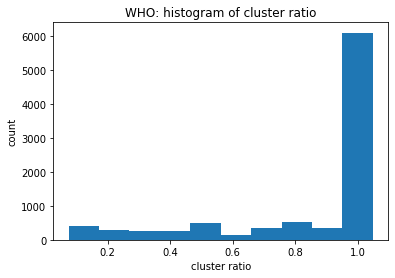

In [29]:
f = plt.hist(who_ratio['cluster_ratio'], bins=10, align='right')
plt.xlabel('cluster ratio')
plt.ylabel('count')
plt.title('WHO: histogram of cluster ratio')

In [30]:
who_decision = eval_points(who_ratio) 

In [31]:
who_decision['eval'].value_counts(sort=False)

0     741
1    6680
2    1801
Name: eval, dtype: int64

In [32]:
who_dropped = drop_points(who_decision)

In [33]:
print("Number of data points at start:", who.shape[0])
print("Number of data points after dropping:", who_dropped.shape[0])

Number of data points at start: 9222
Number of data points after dropping: 3089


In [34]:
# Export results as csv files

#who_decision.to_csv(dataDir + "\\Cleaned\\Single source\\1st round\\who_decision_0919.csv",
#                   index=False)
#who_dropped.to_csv(dataDir + "\\Cleaned\\Single source\\1st round\\who_dropped_0919.csv",
#                   index=False)

## Second round cleaning

Starting from here, points with `eval` of 0 in the first phase are dropped and duplicates within subclusters with `eval` of 1 or 2 are also dropped such that there is only one point representing each subcluster.

A new feature sequence is found using a radius of 1km.

In [35]:
# Data import

dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\DRC"
acasus_dropped = pd.read_csv(dataDir + "\\Cleaned\\Single source\\1st round\\acasus_dropped_0919.csv")
who_dropped = pd.read_csv(dataDir + "\\Cleaned\\Single source\\1st round\\who_dropped_0919.csv")

dataDir2 = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\Fuzzy Match Testing"
acasus_seq2 = gpd.read_file(dataDir2+"\\Fuzzy Match Testing.gdb", driver='FileGDB', 
                       layer= 'acasus_dropped_0919_FindIden')
who_seq2 = gpd.read_file(dataDir2+"\\Fuzzy Match Testing.gdb", driver='FileGDB', 
                       layer= 'who_dropped_0919_FindIden')

In [36]:
# merge feature sequence to original dataset

# minus 1 from IN_FID in who_seq to match index of the original dataset
acasus_seq2['IN_FID'] = acasus_seq2['IN_FID']-1
who_seq2['IN_FID'] = who_seq2['IN_FID']-1

# drop duplicates in IN_FID since some points are assigned to more than 1 cluster
acasus_seq2 = acasus_seq2.sort_values(by=['IN_FID', 'FEAT_SEQ'])\
.drop_duplicates(subset='IN_FID', keep='first')
who_seq2 = who_seq2.sort_values(by=['IN_FID', 'FEAT_SEQ'])\
.drop_duplicates(subset='IN_FID', keep='first')

# add feature sequence to original dataset
acasus_dropped = acasus_dropped.merge(acasus_seq2.drop(columns=['geometry']), 
                           left_index=True, right_on='IN_FID')
who_dropped = who_dropped.merge(who_seq2.drop(columns=['geometry']), 
                                left_index=True, right_on='IN_FID')

### Acasus

In [37]:
print("Number of data points:", acasus_dropped.shape[0])
print("Number of clusters:", acasus_seq2['FEAT_SEQ'].max())

Number of data points: 10840
Number of clusters: 7339


In [45]:
def eval_phase2(df, cluster='FEAT_SEQ_y', decision='eval',
               subcluster_size='subcluster_size', new_decision = 'eval2'):
    
    """Evaluate points within the new cluster.
    0 means drop and 1 means keep.
    decision: column name for first phase evaluation.
    new_decision: column name for second phase evaluation."""
    
    drop = []
    df.sort_values([cluster, decision, subcluster_size], inplace=True)
    df_grouped = df.groupby(cluster)
    
    for name, df_group in df_grouped:
        max_subcluster = df_group[subcluster_size].max()
        
        # There are points with both eval=1 and eval=2 in the cluster
        if df_group[decision].nunique()>1:
            # If there are more than 1 point with eval=1, keep the point with max sublcuster size
            if df_group[df_group[decision]==1].shape[0]>1:
                for idx, row in df_group.iterrows():
                    # Keep only points with eval=1
                    if row[decision]==1 and row[subcluster_size]==max_subcluster:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
            # There is only 1 point with eval=1, just keep that point and drop the rest
            else:
                for idx, row in df_group.iterrows():
                    # Keep only points with eval=1
                    if row[decision]==1:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
        # There are either points with eval=1 or points with eval=2 (exclusive)       
        else:
            for idx, row in df_group.iterrows():
                # Keep only points with the maximum subcluster size
                if row[subcluster_size]==max_subcluster:
                    drop.append(1)
                # Drop all other points   
                else:
                    drop.append(0)
                 
    df[new_decision] = drop
    return df                         

In [46]:
acasus_decision2 = eval_phase2(acasus_dropped)

In [47]:
acasus_decision2['eval2'].value_counts()

1    7965
0    2875
Name: eval2, dtype: int64

In [48]:
# drop points with eval=0 in second phase cleaning
acasus_dropped2 = acasus_decision2[acasus_decision2['eval2']==1]

In [49]:
# Examine the results where there are still ties
counts = acasus_dropped2.groupby('FEAT_SEQ_y').size()
acasus_dropped2[acasus_dropped2['FEAT_SEQ_y'].isin(counts[counts>1].index)]\
.sort_values('FEAT_SEQ_y').head()

,IN_FID,year,month,province1,h_zone1,h_area1,face_name1,fosa_uid,p_code,province2,h_zone2,h_area2,face_name2,type,count_all,haslatlong,OBJECTID,day_original,Type_abv,in_A,with_A,province,in_A_B,with_A_B,WHO_pcount,XCoord,YCoord,Source,tot_count,tot_exist,loc_rate,WHO_rate,rate_share,rate_order,isDublicat,Shape_Leng,uncertaint,OBJECTID_1,IN_FID_x,FEAT_SEQ_x,geometry,latitude,longitude,day,date,type_corr,face_name2_corr,face_name2_type,freq_count,match_name,n_subclusters,match_score,match_type,name_seq,type_seq,clusterID,cluster_size,subcluster_size,cluster_ratio,eval,IN_FID_y,FEAT_SEQ_y,eval2
85,68,2020.0,5.0,tu Tshuapa Province,tu Djolu Zone de Santé,tu Bofola Aire de Santé,tu Bofola Centre de Santé,wUQzvnhllVv,tu,Tshuapa,Djolu,Bofola,Bofola,Centre de Sante,15,6,0,0.0,,,,,,,0,0.0,0.0,,0,0,0,0,,0,,0.0,0.0,430,99,66,POINT (22.46030720000005 0.6657186000000479),0.665719,22.460307,1.0,2020-05-01,Centre de Sante,Bofola,Bofola Centre de Sante,1,Bofola,1,NaN,Self,1.0,1.0,6600101,1,1,1.0,2,68,64,1
86,281,2019.0,6.0,tu Tshuapa Province,tu Djolu Zone de Santé,tu Bofola Aire de Santé,tu Bofola Centre de Santé,wUQzvnhllVv,tu,Tshuapa,Djolu,Bofola,Bofola,Centre de Sante,15,6,0,0.0,,,,,,,0,0.0,0.0,,0,0,0,0,,0,,0.0,0.0,1810,1621,258,POINT (22.45937780000003 0.6672075000000746),0.667208,22.459378,1.0,2019-06-01,Centre de Sante,Bofola,Bofola Centre de Sante,1,Bofola,1,NaN,Self,1.0,1.0,25800101,1,1,1.0,2,281,64,1
131,111,2020.0,5.0,tu Tshuapa Province,tu Lingomo Zone de Santé,tu Wanga Aire de Santé,tu Wanga Centre de Santé,szVroRDt79S,tu,Tshuapa,Lingomo,Wanga,Wanga,Centre de Sante,20,9,0,0.0,,,,,,,0,0.0,0.0,,0,0,0,0,,0,,0.0,0.0,781,164,105,POINT (22.10120970000003 1.500889100000052),1.500889,22.101210,1.0,2020-05-01,Centre de Sante,Wanga,Wanga Centre de Sante,2,Wanga,2,NaN,Self,2.0,1.0,10500201,2,1,0.5,2,111,106,1
132,112,2020.0,4.0,tu Tshuapa Province,tu Lingomo Zone de Santé,tu Wanga Aire de Santé,tu Wanga Centre de Santé,szVroRDt79S,tu,Tshuapa,Lingomo,Wanga,Wanga,Centre de Sante,20,9,0,0.0,,,,,,,0,0.0,0.0,,0,0,0,0,,0,,0.0,0.0,782,163,106,POINT (22.10106720000005 1.501555500000052),1.501556,22.101067,1.0,2020-04-01,Centre de Sante,Wanga,Wanga Centre de Sante,1,Wanga,1,NaN,Self,1.0,1.0,10600101,1,1,1.0,2,112,106,1
185,160,2020.0,5.0,tu Tshuapa Province,tu Wema Zone de Santé,tu Wema Aire de Santé,tu Pilote Wema Centre de Santé,C4IdEwhvqgo,tu,Tshuapa,Wema,Wema,Pilote Wema,Centre de Sante,16,5,0,0.0,,,,,,,0,0.0,0.0,,0,0,0,0,,0,,0.0,0.0,1160,236,150,POINT (21.62379500000003 -0.4829382999999439),-0.482938,21.623795,1.0,2020-05-01,Centre de Sante,Pilote Wema,Pilote Wema Centre de Sante,1,Pilote Wema,1,NaN,Self,1.0,1.0,15000101,1,1,1.0,2,160,154,1


### WHO

In [50]:
print("Number of data points:", who_dropped.shape[0])
print("Number of clusters:", who_seq2['FEAT_SEQ'].max())

Number of data points: 3089
Number of clusters: 2828


In [51]:
who_decision2 = eval_phase2(who_dropped)

In [52]:
who_decision2['eval2'].value_counts(sort=False)

0     200
1    2889
Name: eval2, dtype: int64

In [53]:
# drop points with eval=0 in second phase cleaning
who_dropped2 = who_decision2[who_decision2['eval2']==1]

In [54]:
# Examine the results where there are still ties
counts = who_dropped2.groupby('FEAT_SEQ_y').size()
who_dropped2[who_dropped2['FEAT_SEQ_y'].isin(counts[counts>1].index)]\
.sort_values('FEAT_SEQ_y').head()

,IN_FID,date,province,h_zone1,h_area1,face_name1,fosa_uid,province2,h_zone2,h_area2,face_name2,type,count_all,in_A_B,with_A_B,geometry,IN_FID_x,FEAT_SEQ_x,latitude,longitude,date_dt,type_corr,face_name2_corr,face_name2_type,freq_count,match_name,n_subclusters,match_score,match_type,name_seq,type_seq,clusterID,cluster_size,subcluster_size,cluster_ratio,eval,IN_FID_y,FEAT_SEQ_y,eval2
78,78,"Tuesday, 2 April 2019",TSHUAPA,LINGOMO,Yofaka,CS Yofaka,LrmzDoXkVFR,Tshuapa,Lingomo,Yofaka,Yofaka,Centre de Sante,2,YES,YES,POINT (22.21575167000003 0.965191667000056),127,77,0.965192,22.215752,2019-04-02,Centre de Sante,Yofaka,Yofaka Centre de Sante,1,Yofaka,1,NaN,Self,1.0,1.0,7700101,1,1,1.0,2,78,79,1
79,79,"Tuesday, 12 November 2019",TSHUAPA,LINGOMO,Yofaka,CS Yofaka,LrmzDoXkVFR,Tshuapa,Lingomo,Yofaka,Yofaka,Centre de Sante,2,YES,YES,POINT (22.21582000000006 0.9666683330000296),128,78,0.966668,22.215820,2019-11-12,Centre de Sante,Yofaka,Yofaka Centre de Sante,1,Yofaka,1,NaN,Self,1.0,1.0,7800101,1,1,1.0,2,79,79,1
126,126,"Thursday, 21 September 2017",TANGANYIKA,KALEMIE,CLINIQUE D'ETAT,CLINIQUE D'ETAT,wpFqoAXmwZ4,Tanganyika,Kalemie,Clinique,Etat,Clinique,4,YES,YES,POINT (29.19447990000003 -5.947304799999927),239,125,-5.947305,29.194480,2017-09-21,Clinique,Etat,Etat Clinique,1,Etat,1,NaN,Self,1.0,1.0,12500101,1,1,1.0,2,126,124,1
128,127,"Thursday, 5 December 2019",TANGANYIKA,KALEMIE,CLINIQUE D'ETAT,CLINIQUE D'ETAT,wpFqoAXmwZ4,Tanganyika,Kalemie,Clinique,Etat,Clinique,4,YES,YES,POINT (29.19509333000008 -5.94850166699996),240,126,-5.948502,29.195093,2019-12-05,Clinique,Etat,Etat Clinique,1,Etat,1,NaN,Self,1.0,1.0,12600101,1,1,1.0,2,127,124,1
127,128,"Wednesday, 22 August 2018",TANGANYIKA,KALEMIE,CLINIQUE D'ETAT,CLINIQUE NICHE,wpFqoAXmwZ4,Tanganyika,Kalemie,Clinique,Etat,Clinique,4,YES,YES,POINT (29.18826000000007 -5.944783332999975),241,127,-5.944783,29.188260,2018-08-22,Clinique,Etat,Etat Clinique,1,Etat,1,NaN,Self,1.0,1.0,12700101,1,1,1.0,2,128,124,1


In [135]:
# export results as csv files
#acasus_decision2.to_csv(dataDir + "\\Cleaned\\Single source\\2nd round\\acasus_decision2_0921.csv",
#                   index=False)
#who_decision2.to_csv(dataDir + "\\Cleaned\\Single source\\2nd round\\who_decision2_0921.csv",
#                   index=False)

#acasus_dropped2.to_csv(dataDir + "\\Cleaned\\Single source\\2nd round\\acasus_dropped2_0921.csv",
#                   index=False)
#who_dropped2.to_csv(dataDir + "\\Cleaned\\Single source\\2nd round\\who_dropped2_0921.csv",
#                   index=False)